## _*Quantum Emoticon*_ 

The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.

For more information about how to use the IBM Q experience (QX), consult the [tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), or check out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
### Contributors
James R. Wootton, University of Basel; 
Anna Phan, IBM Research

This program aims to do some of the same jobs as "Hello World" does for classical programming.

Specifically:
* It is simple;
* It performs and understandable and relatable task;
* It demonstrates simple principles of the programming language;
* It shows how to produce and look at an output.

Anything that can be done with bits can be done with qubits. Simply leave a qubit in its initialized value for the state *0*, or use an operation with the effect of a NOT gate (such as *X* or *Y*) to rotate it to a *1*. Each qubit then becomes a bit, allowing us to implement "Hello, World!" directly on a quantum computer.

In practice, it is not so straightforward. ASCII encoding of "Hello, World!" requires over 100 bits, and therefore over 100 qubits. Current quantum devices are not yet large enough for the job.

However, two ASCII characters require only 16 (qu)bits. Writing an emoticon like ;) can therefore be done using *ibmqx5*.

The string corresponding to ;) is
    
    ;)  =  '0011101100101001'

To prepare this state we can perform an *X* on qubits 0, 3, 5, 8, 9, 11, 12, 13. Here we number the bits from 0 to 15, from right to left.

Of course, just writing a bit string in some qubits isn't very quantum. Instead we can prepare a superposition of two different emoticons. We choose ;) and 8), which correspond to the bit strings

    8)  =  '0011100000101001'
    ;)  =  '0011101100101001'

Note that these strings differ only on bits 8 and 9. It is therefore only these on which the superposition must be prepared. The superposition will be of the '00' of 8), and the '11' of ;) , and so will be a standard [Bell state](https://github.com/QISKit/qiskit-tutorial/blob/master/2_quantum_information/superposition_and_entanglement.ipynb).

We'll now implement this.

In [1]:
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit, execute
from qiskit.tools.visualization import plot_histogram

# set up registers and program
qr = QuantumRegister(16)
cr = ClassicalRegister(16)
qc = QuantumCircuit(qr, cr)

# rightmost eight (qu)bits have ')' = 00101001
qc.x(qr[0])
qc.x(qr[3])
qc.x(qr[5])

# second eight (qu)bits have superposition of
# '8' = 00111000
# ';' = 00111011
# these differ only on the rightmost two bits
qc.h(qr[9]) # create superposition on 9
qc.cx(qr[9],qr[8]) # spread it to 8 with a cnot
qc.x(qr[11])
qc.x(qr[12])
qc.x(qr[13])

# measure
for j in range(16):
    qc.measure(qr[j], cr[j])

We first prepare set up the credentials required to access the devices.

In [8]:
from qiskit import register, available_backends, get_backend

#import Qconfig and set APIToken and API url
try:
    import sys
    sys.path.append("../") # go to parent dir
    import Qconfig
    qx_config = {
        "APItoken": Qconfig.APItoken,
        "url": Qconfig.config['url']}
except Exception as e:
    print(e)
    qx_config = {
        "APItoken":"YOUR_TOKEN_HERE",
        "url":"https://quantumexperience.ng.bluemix.net/api"}

#set api
register(qx_config['APItoken'], qx_config['url'])

We'll now run the circuit on the simulator for 128 shots (so we don't need to wait in the *ibmqx5* queue) and plot the results. 

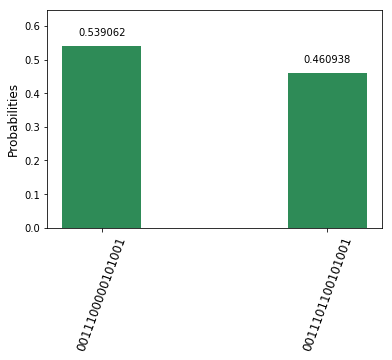

In [3]:
backend = "ibmqx_hpc_qasm_simulator" 
shots_sim = 128

job_sim = execute(qc, backend, shots=shots_sim)
if job_sim.running == False:
    stats_sim = job_sim.result().get_counts()
else:
    print(job_sim.running)
    time.sleep(60)

plot_histogram(stats_sim)

The above results in *stats* tell us how many times each bit string was found as a result. To make our emoticon, we convert the bit strings into ASCII characters. We also calculate the fraction of shots for which each result occurred. The most common results are then printed to screen.

This gives us a list of characters and probabilities. But that isn't very fun. For something more visual, we use matplotlib to create an image in which the all the characters included in the result are printed on top of each other. The alpha channel of each character is set to the fraction of shots for which that result occurred. For our simulator results, this is approximately equally split between 8) and ;).

We will write this transformation and visualisation from results to ASCII characters as a function so we can reuse it later when we run the smiley circuit on the *ibmqx5* device. 

0.4609375	;)
0.5390625	8)


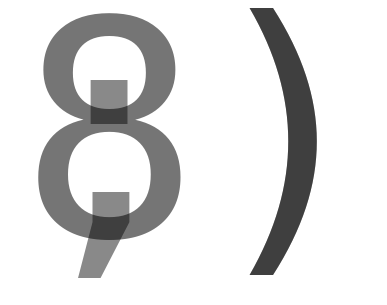

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='monospace')

def plot_smiley (stats, shots):
    for bitString in stats:
        char = chr(int( bitString[0:8] ,2)) # get string of the leftmost 8 bits and convert to an ASCII character
        char += chr(int( bitString[8:16] ,2)) # do the same for string of rightmost 8 bits, and add it to the previous character
        prob = stats[bitString] / shots # fraction of shots for which this result occurred
        # create plot with all characters on top of each other with alpha given by how often it turned up in the output
        plt.annotate( char, (0.5,0.5), va="center", ha="center", color = (0,0,0, prob ), size = 300)
        if (prob>0.05): # list prob and char for the dominant results (occurred for more than 5% of shots)
            print(str(prob)+"\t"+char)
    plt.axis('off')
    plt.show()
    
plot_smiley(stats_sim, shots_sim)

We'll now run the smiley circuit on *ibmqx5*, after checking that the device is online. Given the noise on the device, our smiley won't be as clean as our previous run on the simulator.

Status of ibmqx5: {'available': True, 'pending_jobs': 0, 'name': 'ibmqx5'}
The device is available, so we'll submit the job.
0.179	8)
0.147	;)


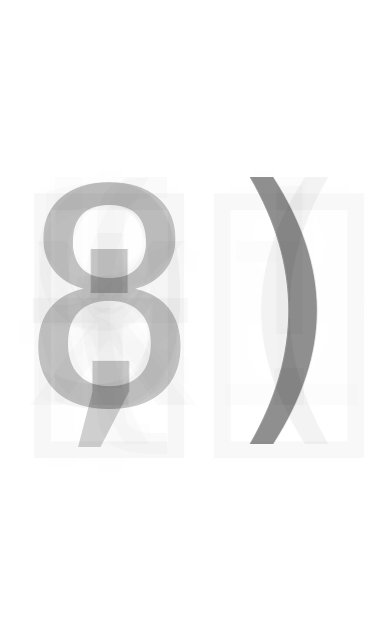

In [5]:
backends = available_backends()
backend = get_backend('ibmqx5')
print('Status of ibmqx5:',backend.status)

if backend.status["available"] is True:
    print("\nThe device is available, so we'll submit the job.")
    
    shots_device = 1000
    job_device = execute(qc, backend, shots=shots_device)
    stats_device = job_device.result().get_counts()
else:
    print("\nThe device is not available. Try again later.")
    
plot_smiley(stats_device, shots_device)

And there you have it. A program to take one of the world's most advanced devices and made a smiley with it. A quantum smiley!

An alternative introduction to this program can be found [here](https://medium.com/@decodoku/making-a-quantum-computer-smile-cee86a6fc1de).

In [6]:
print("Installed packages are as the following")
!python --version
print()
!conda list 'qiskit|IBMQuantumExperience|numpy|scipy|matplotlib'

Installed packages are as the following
Python 3.6.0 :: Anaconda custom (x86_64)

# packages in environment at /Users/james/anaconda:
#
IBMQuantumExperience      1.9.0                     <pip>
matplotlib                2.0.0               np111py36_0  
matplotlib                2.1.2                     <pip>
numpy                     1.13.3                    <pip>
numpy                     1.11.3                   py36_0  
numpydoc                  0.6.0                    py36_0  
qiskit                    0.5.0                     <pip>
scipy                     0.19.1                    <pip>
scipy                     0.18.1              np111py36_1  
